In [2]:
import scipy.io as sio
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from fieldmodel import GeodesicFieldModel as GFM
from fieldmodel import utilities
from fieldmodel import plotting

Let's begin by loading the demo data in the ```./data/``` directory.

In [3]:
# get target (X,Y) spatial coordinats of our data
tx_file = '../data/target.X.mat'
tx = sio.loadmat(tx_file)['x'].squeeze()

ty_file = '../data/target.Y.mat'
ty = sio.loadmat(ty_file)['y'].squeeze()

# get pairwise distance matrix from (X,Y) coordinates
# these distance are computed from the adjacency matrix of (X,Y) 
dist_file = '../data/distance.mat'
dist = sio.loadmat(dist_file)['apsp']

# load the scalar field that we'll fit densities to
field_file = '../data/scalar_field.mat'
field = sio.loadmat(field_file)['field'].squeeze()

Let's play around first with some parameters for identifying and selecting local maxima.  We can use the ```find_peaks``` and ```peak_neighborhood``` functions from the ```utilities``` module.

```find_peaks``` takes 3 parameters: distance matrix, a neighborhood size, and the scalar field.  The neighborhood size parameter defines the minimum distance required between local maxima.  We don't want to explore too many areas of our scalar field, so we want to downsample the number of points we're interested in.  In the first example, we'll use a neighborhood size of ```10```.

In [4]:
n_size = 10
peaks = util.find_peaks(dist=dist, 
                        n_size=n_size, 
                        sfield=field)

We can visualize where our peaks are in the scalar field by using the ```plot_peaks``` function from the ```plotting``` module.

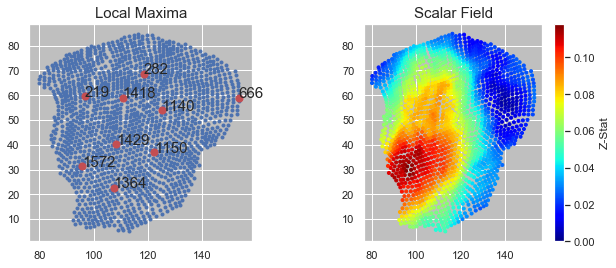

In [5]:
F = plotting.plot_peaks(peaks=peaks, 
                        sfield=field, 
                        x=tx, y=ty, 
                        field_kwargs={'label': 'Z-Stat'})

Let's see what happens when we increase the neighborhood size to ```15```.

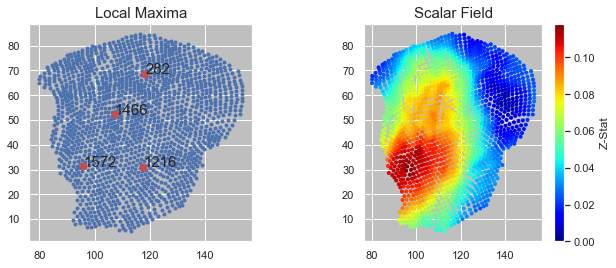

In [6]:
n_size = 15
peaks = util.find_peaks(dist=dist, 
                        n_size=n_size, 
                        sfield=field)
F = plotting.plot_peaks(peaks=peaks, 
                        sfield=field, 
                        x=tx, y=ty, 
                        field_kwargs={'label': 'Z-Stat'})

We see that we've sampled fewer local maxima in the scalar field.

Now, we also want to define the *search space* for our mean location -- that is, what scalar field points do we consider as candidates for our optimal mean parameter?  To do this, we use the ```peak_neighborhood``` function, that takes in 3 parameters: distance matrix, a neighborhood size parameter, and the peak locations identified previously.

In this case, the neighborhood size parameter dicates the radial distance from each peak, that defines a circular area around each peak, within which candidate mean locations exist.  We can plot the search space using the ```plot_searchspace``` function in the ```plotting``` module.

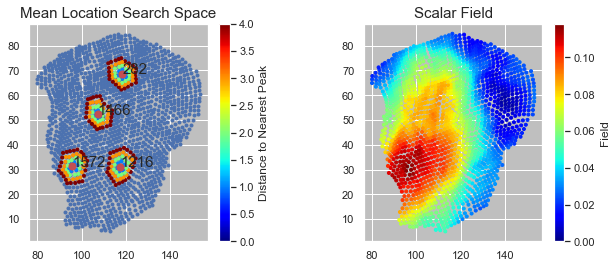

In [7]:
h_size = 5
nhood = util.peak_neighborhood(apsp=dist, 
                               h_size=h_size, 
                               peaks=peaks)

F = plotting.plot_searchspace(dist=dist,
                              peaks=peaks,
                              nhood=nhood,
                              sfield=field,
                              x=tx, y=ty)

If we increase this neighborhood parameter, we'll increase the size of our search space.

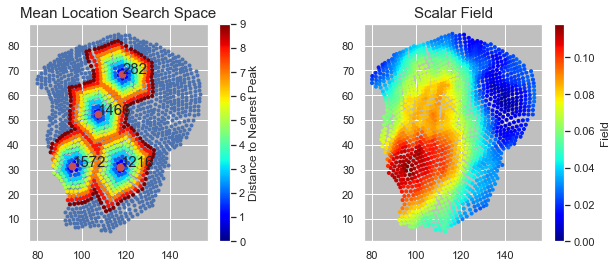

In [8]:
h_size = 10
nhood = util.peak_neighborhood(apsp=dist, 
                               h_size=h_size, 
                               peaks=peaks)

F = plotting.plot_searchspace(dist=dist,
                              peaks=peaks,
                              nhood=nhood,
                              sfield=field,
                              x=tx, y=ty)

Let use a minimum inter-peak distance of ```10``` and search-space size of ```10```.  We can now initialize and fit our fieldmodel.  The fitting procedure will consider every location within the search space as a candidate mean location.  Then, for each candidate location, will fit a density centered at that location.  For each candidate location, this means will fit an optimal amplitude and sigma value, and consequentially, locally minimal cost.

Of these candidate locations, the location with the lowest cost is chosen as the globally optimal mean location, and it's associate amplitude and sigma values are the globally optimal parameters estimates.

In [9]:
peak_distance = 10
search_distance = 10

G = GFM.FieldModel(amplitude=False, 
                   metric='pearson', 
                   peak_size=peak_distance, 
                   hood_size=search_distance)

G.fit(data=field, distances=dist, x=tx, y=ty)

The fitted amplitude and sigma parameter estimates are stored in the ```optimal_``` field, while the fitted mean index is store in the ```mu_``` field.

In [14]:
print('Amplitude:  %.1f\nSigma:  %.2f' % (G.optimal_[0], G.optimal_[1]))

Amplitude:  1.0
Sigma:  14.27


Since the field model tests each location within the search space, and optimizes over amplitude and sigma values at the location, we estimate an optimal sigma, amplitude, and cost at each location in the search space, **in addition to** the global optimal estimates.  We can visualize maps of these local optima estimates by using the ```FieldModel.plot``` function 

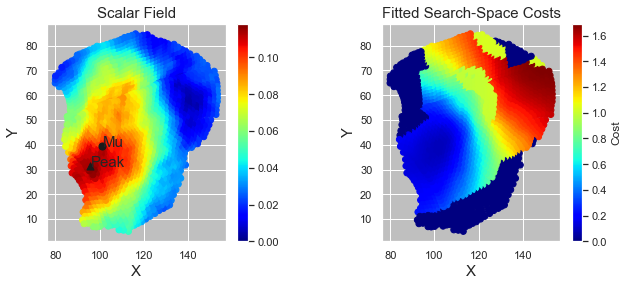

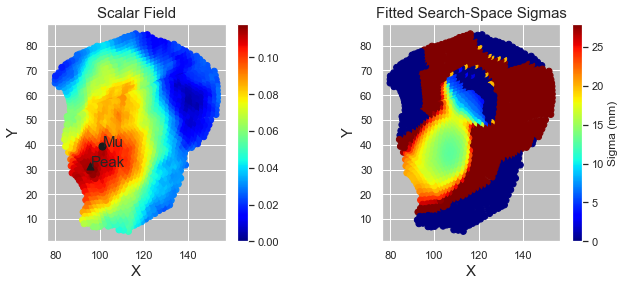

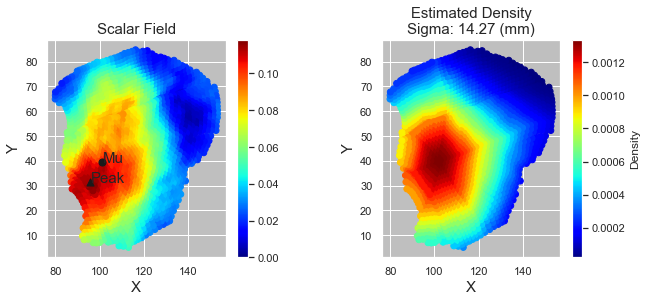

In [186]:
for f in ['cost', 'sigma', 'pdf']:
    F = G.plot(field=f)
    plt.savefig('/Users/kristianeschenburg/Documents/Code/fieldmodel/demos/%s.png' % (f), 
               bbox_inches='tight')
    plt.show()
    plt.close()